In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.metrics import mean_absolute_error, mean_squared_error

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 7588 entries, 1990-01-01 to 2010-10-10
Data columns (total 1 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Ex_rate  7588 non-null   float64
dtypes: float64(1)
memory usage: 118.6 KB
None
           Ex_rate
count  7588.000000
mean      0.776974
std       0.136620
min       0.483297
25%       0.701422
50%       0.761377
75%       0.873477
max       1.102536


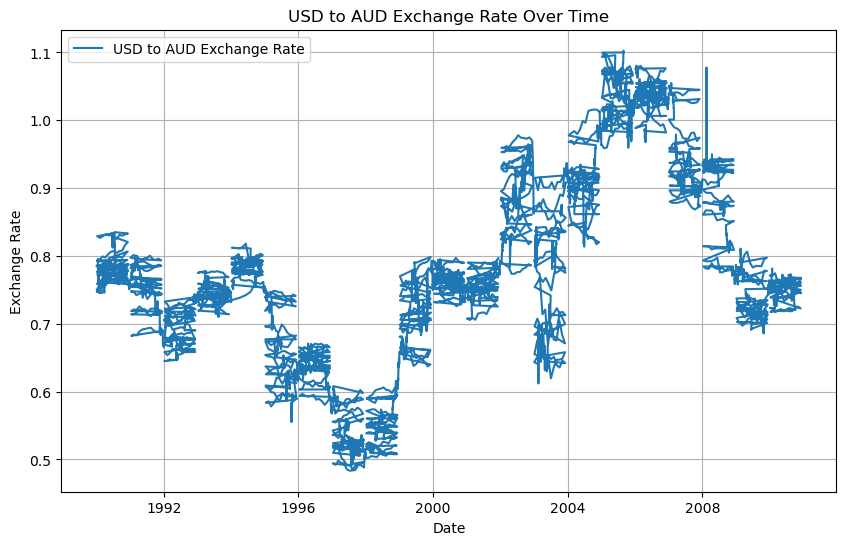

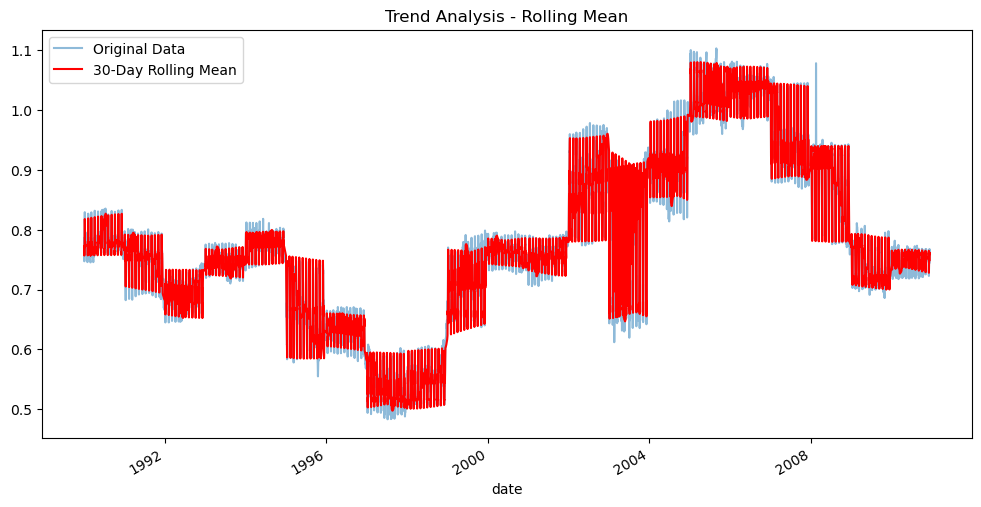

<Figure size 1200x800 with 0 Axes>

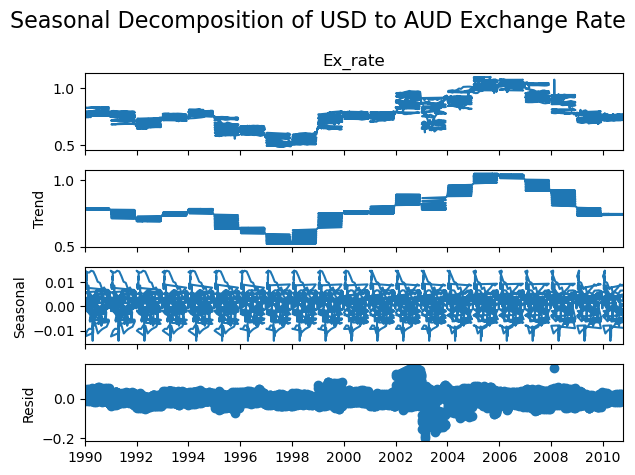

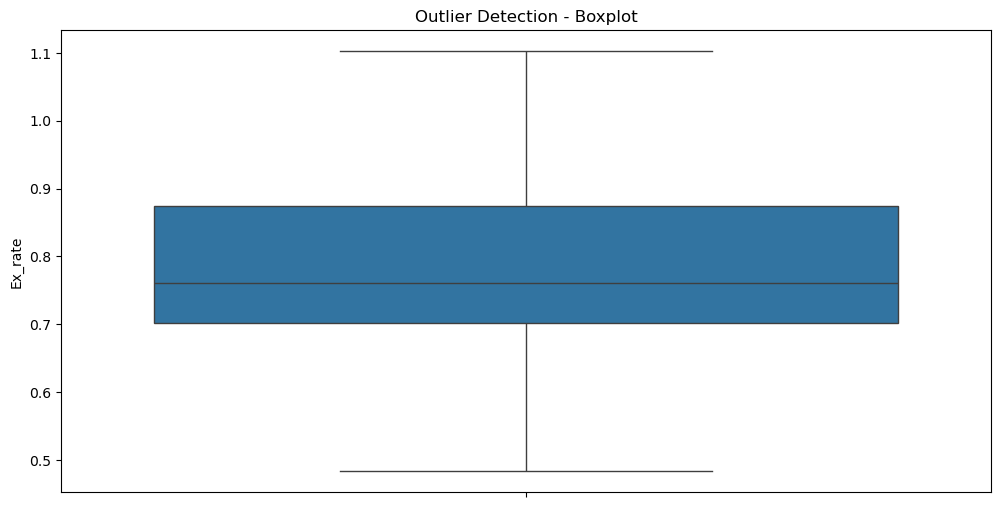


Number of Outliers Detected: 0


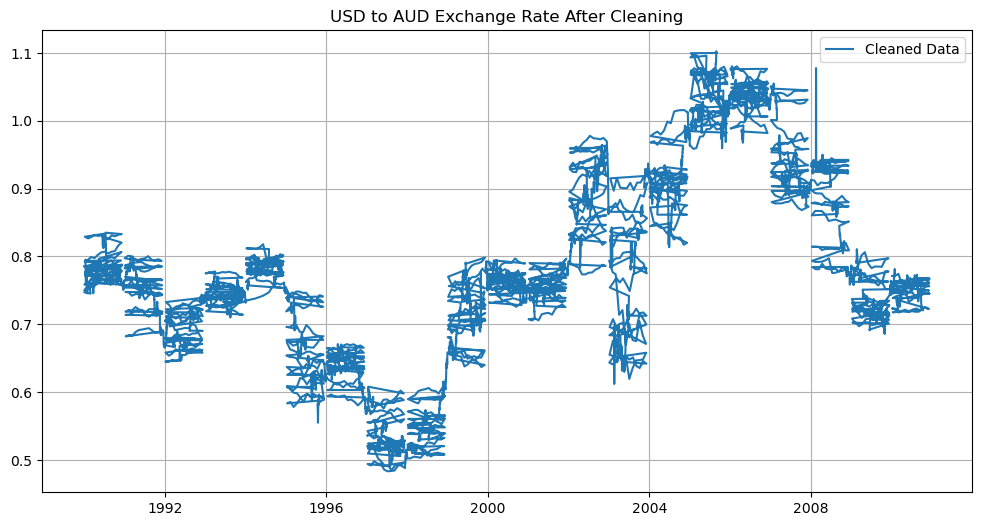

ADF Test for Original Data:
ADF Statistic: -1.6650
p-value: 0.4492
The series is non-stationary.

ADF Test for Differenced Data:
ADF Statistic: -99.3934
p-value: 0.0000
The series is stationary.


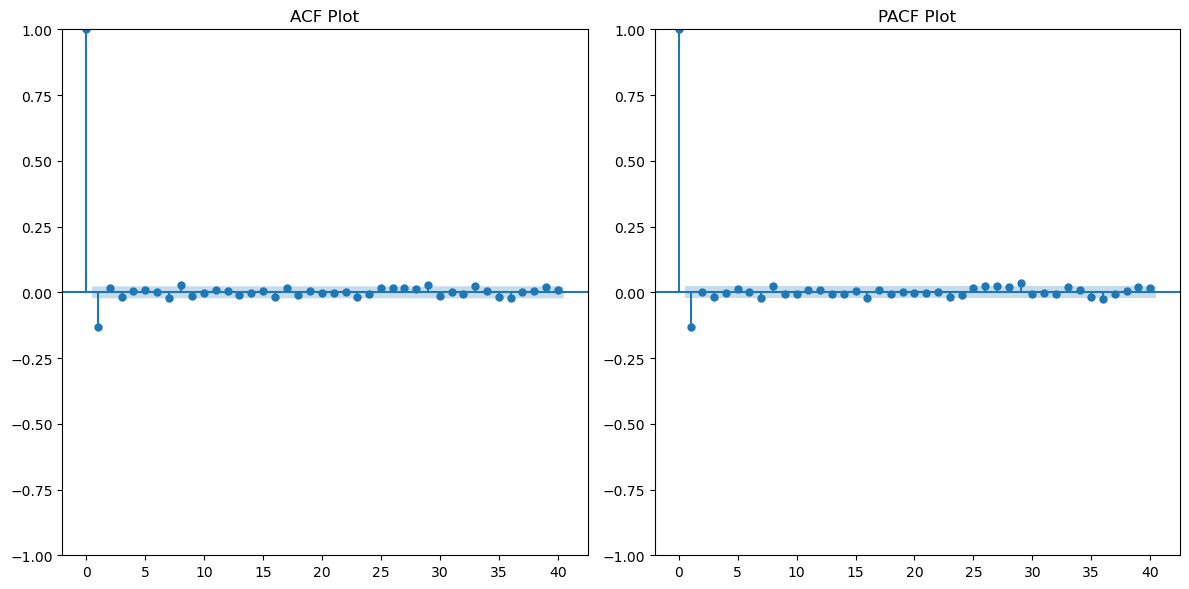

                               SARIMAX Results                                
Dep. Variable:                Ex_rate   No. Observations:                  249
Model:                 ARIMA(1, 1, 1)   Log Likelihood                 537.585
Date:                Fri, 18 Jul 2025   AIC                          -1069.169
Time:                        01:32:40   BIC                          -1058.629
Sample:                    01-31-1990   HQIC                         -1064.926
                         - 09-30-2010                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5335      0.471      1.132      0.258      -0.390       1.457
ma.L1         -0.4614      0.492     -0.938      0.348      -1.425       0.502
sigma2         0.0008   5.64e-05     13.588      0.0

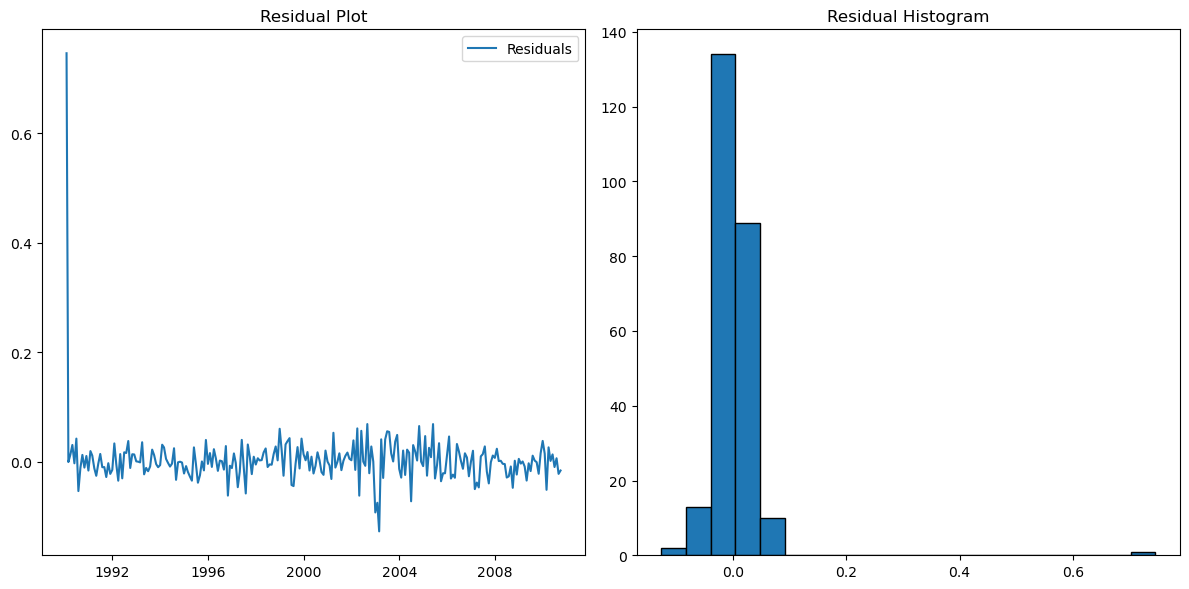

Ljung-Box Test Results:
      lb_stat  lb_pvalue
10  3.744388   0.958142


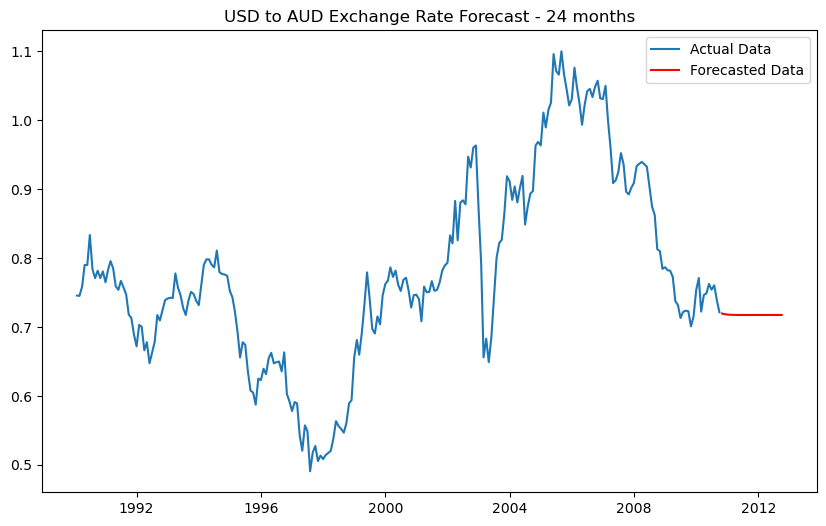

RMSE: 0.0414
MAE: 0.0328
RMSE: 0.2671
MAE: 0.2333


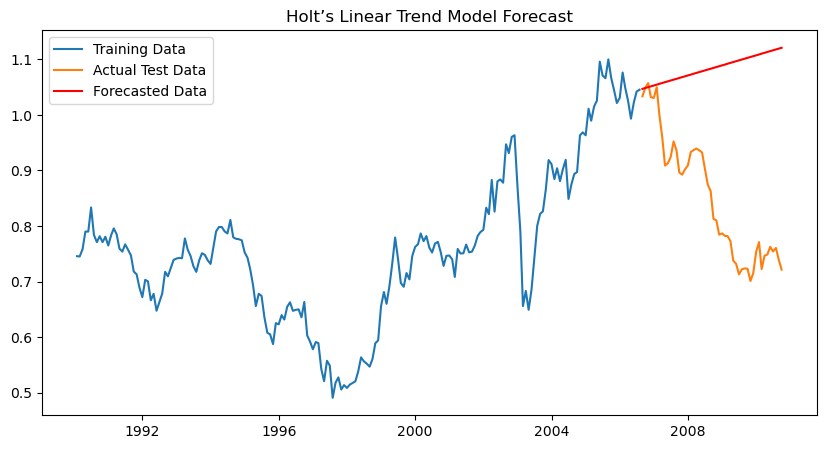

In [2]:
def TS():
    try:

      file_path = 'exchange_rate.csv'
      data = pd.read_csv(file_path, parse_dates=['date'], index_col='date')

      # Step 2: Initial Exploration
      print(data.info())
      print(data.describe())

      # Visualizing the USD to AUD exchange rate
      plt.figure(figsize=(10, 6))
      plt.plot(data['Ex_rate'], label='USD to AUD Exchange Rate')
      plt.title('USD to AUD Exchange Rate Over Time')
      plt.xlabel('Date')
      plt.ylabel('Exchange Rate')
      plt.legend()
      plt.grid(True)
      plt.savefig('USD to AUD Exchange Rate Over Time.png')
      plt.show()

      # Step 4: Trend Analysis using Rolling Mean
      plt.figure(figsize=(12, 6))
      data['Ex_rate'].plot(label='Original Data', alpha=0.5)
      data['Ex_rate'].rolling(window=30).mean().plot(label='30-Day Rolling Mean', color='red')
      plt.title('Trend Analysis - Rolling Mean')
      plt.legend()
      plt.savefig('Trend Analysis - Rolling Mean.png')
      plt.show()

      # Step 5: Seasonality Analysis using Decomposition
      decomposition = seasonal_decompose(data['Ex_rate'], model='additive', period=365)
      plt.figure(figsize=(12, 8))
      decomposition.plot()
      plt.suptitle('Seasonal Decomposition of USD to AUD Exchange Rate', fontsize=16)
      plt.tight_layout()
      plt.savefig('Seasonal Decomposition of USD to AUD Exchange Rate.png')
      plt.show()

      # Step 6: Outlier Detection using IQR
      Q1 = data['Ex_rate'].quantile(0.25)
      Q3 = data['Ex_rate'].quantile(0.75)
      IQR = Q3 - Q1
      outlier_condition = (data['Ex_rate'] < (Q1 - 1.5 * IQR)) | (data['Ex_rate'] > (Q3 + 1.5 * IQR))

      plt.figure(figsize=(12, 6))
      sns.boxplot(data['Ex_rate'])
      plt.title('Outlier Detection - Boxplot')
      plt.savefig('Outlier Detection - Boxplot.png')
      plt.show()

      print(f"\nNumber of Outliers Detected: {outlier_condition.sum()}")

      # Step 7: Handling Missing Values & Outliers
      # Forward fill missing values
      data['Ex_rate'].fillna(method='ffill', inplace=True)

      # Optionally handle outliers (e.g., replacing with rolling mean)
      data['Ex_rate'] = np.where(outlier_condition, 
                           data['Ex_rate'].rolling(window=10, min_periods=1).mean(), 
                           data['Ex_rate'])

      # Final Visualization After Cleaning
      plt.figure(figsize=(12, 6))
      plt.plot(data['Ex_rate'], label='Cleaned Data')
      plt.title('USD to AUD Exchange Rate After Cleaning')
      plt.legend()
      plt.grid(True)
      plt.savefig('USD to AUD Exchange Rate After Cleaning.png')
      plt.show()

      # Step 2: ADF Test for Stationarity
      def adf_test(series):
          result = adfuller(series)
          print(f'ADF Statistic: {result[0]:.4f}')
          print(f'p-value: {result[1]:.4f}')
          if result[1] <= 0.05:
              print("The series is stationary.")
          else:
              print("The series is non-stationary.")

      print("ADF Test for Original Data:")
      adf_test(data['Ex_rate'])

      # Step 3: Differencing for Stationarity (if needed)
      data_diff = data['Ex_rate'].diff().dropna()

      print("\nADF Test for Differenced Data:")
      adf_test(data_diff)

      # Step 4: ACF and PACF Plots for ARIMA Parameter Selection
      plt.figure(figsize=(12, 6))

      plt.subplot(1, 2, 1)
      plot_acf(data_diff, lags=40, ax=plt.gca(), alpha=0.05)
      plt.title('ACF Plot')

      plt.subplot(1, 2, 2)
      plot_pacf(data_diff, lags=40, ax=plt.gca(), alpha=0.05)
      plt.title('PACF Plot')

      plt.tight_layout()
      plt.savefig('ACF and PACF Plots for ARIMA Parameter Selection.png')
      plt.show()

      data = data.asfreq('M')  # Ensuring monthly frequency
      data.dropna(inplace=True)

      #Model Building - ARIMA
      model = ARIMA(data, order=(1, 1, 1))
      model_fit = model.fit()

      # Summary of the model
      print(model_fit.summary())

      # Residual Analysis
      residuals = model_fit.resid

      plt.figure(figsize=(12, 6))

      plt.subplot(1, 2, 1)
      plt.plot(residuals, label='Residuals')
      plt.title('Residual Plot')
      plt.legend()
    

      plt.subplot(1, 2, 2)
      plt.hist(residuals, bins=20, edgecolor='black')
      plt.title('Residual Histogram')
      plt.tight_layout()
      plt.savefig('Residual.png')
      plt.show()

      # Ljung-Box Test for residual independence
      lb_test = acorr_ljungbox(residuals, lags=[10], return_df=True)
      print("Ljung-Box Test Results:\n", lb_test)

      forecast_steps = 24  # Example: Forecast for 24 months
      forecast = model_fit.forecast(steps=forecast_steps)

      # Visualization
      plt.figure(figsize=(10, 6))
      plt.plot(data, label='Actual Data')
      plt.plot(forecast, label='Forecasted Data', color='red')
      plt.title('USD to AUD Exchange Rate Forecast - 24 months')
      plt.legend()
      plt.savefig('USD to AUD Exchange Rate Forecast - 24 months.png')
      plt.show()

      # Assume `test` is your test data
      rmse = np.sqrt(mean_squared_error(data[-forecast_steps:], forecast))
      mae = mean_absolute_error(data[-forecast_steps:], forecast)

      print(f'RMSE: {rmse:.4f}')
      print(f'MAE: {mae:.4f}')


      # Load the dataset
      dataExp = pd.read_csv("exchange_rate.csv", parse_dates=['date'], index_col='date')
      dataExp = dataExp['Ex_rate'].fillna(method='ffill')  # Handling missing values
      dataExp = dataExp.asfreq('M')  # Ensuring monthly frequency
      dataExp.dropna(inplace=True)

      # Train-Test Split
      train_size = int(len(dataExp) * 0.8)
      train, test = dataExp[:train_size], dataExp[train_size:]

      # Holt's Linear Trend Model
      model1 = ExponentialSmoothing(train, trend='add', seasonal=None)
      fitted_model1 = model1.fit(optimized=True)

      # Forecasting
      forecast = fitted_model1.forecast(len(test))

      # Evaluation
      rmse = np.sqrt(mean_squared_error(test, forecast))
      mae = mean_absolute_error(test, forecast)

      print(f"RMSE: {rmse:.4f}")
      print(f"MAE: {mae:.4f}")

      # Visualization
      plt.figure(figsize=(10, 5))
      plt.plot(train, label='Training Data')
      plt.plot(test, label='Actual Test Data')
      plt.plot(forecast, label='Forecasted Data', color='red')
      plt.title('Holt’s Linear Trend Model Forecast')
      plt.legend()
      plt.savefig('Holt’s Linear Trend Model Forecast.png')
      plt.show()
    
    except FileNotFoundError:
      print("Error")

TS()